# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
historical_positions.iloc[-1]

ETHUSDT          0.055720
ENSUSDT          1.348701
BBUSDT         116.412195
LPTUSDT          1.609294
NEARUSDT         0.048380
RNDRUSDT         4.245345
UMAUSDT          0.038808
USDTUSDT        26.088272
MKRUSDT          0.000046
TNSRUSDT        18.365145
FETUSDT         11.406843
SOLUSDT          1.785416
JASMYUSDT    12539.286069
TRXUSDT        485.974547
PEPEUSDT         0.240000
BNBUSDT         -0.118000
BTCUSDT          0.005233
XRPUSDT          0.846388
NOTUSDT          2.000000
OMUSDT         452.713780
Name: 2024-09-26 00:00:00, dtype: float64

In [11]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [12]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [13]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [14]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total PnL')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.9350,2153.7005,1.0000,-131.8862,-31.2346,-163.1208
JASMYUSDT,387.4585,256.2418,0.1190,0.0000,-131.2167,-131.2167
ETHUSDT,250.7473,181.8068,0.0844,0.0000,-68.9405,-68.9405
BBUSDT,60.1761,39.9643,0.0186,-39.7331,-20.2117,-59.9448
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
BNBUSDT,1.1421,1.0274,0.0005,-10.6060,-0.1147,-10.7207
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,77.7107,0.0361,-10.7239,0.8417,-9.8822
XRPUSDT,0.0000,0.0000,0.0000,-6.1145,0.0000,-6.1145
MKRUSDT,0.0000,0.0000,0.0000,-6.0975,0.0000,-6.0975


In [15]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [16]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [17]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [18]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [19]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [20]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

In [21]:
positions=positions.sort_index()

In [22]:
positions.index=pd.to_datetime(positions.index)

In [23]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [24]:
positions.to_excel('Positions.xlsx')
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)
quantities=pd.concat([quantities,quantities_history])

In [25]:
quantities.to_excel('Quantities.xlsx')

In [26]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [27]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [28]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [29]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [30]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [31]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [32]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

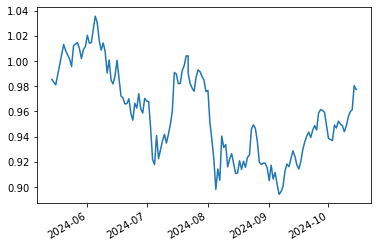

In [33]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [34]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [35]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [36]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XECUSDT',
       'XLMUSDT', 'XRPUSDT'],
      dtype='object')

In [37]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [38]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9333
OMUSDT,0.0239
BNBUSDT,0.0182
TRXUSDT,0.0178
PEPEUSDT,0.0051
SUIUSDT,0.0018
FDUSDUSDT,0.0000
JASMYUSDT,0.0000
WBTCUSDT,0.0000
BTCUSDT,0.0000


In [39]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.466900
BTCUSDT,0.400000
PEPEUSDT,0.060889
BNBUSDT,0.055670
SUIUSDT,0.016541


In [40]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [41]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.692422
OMUSDT,0.307578


## Real Portfolio vs Optimal

In [42]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,719.669208,0.334155,0.307578,0.026577
BTCUSDT,600.012166,0.278596,0.000000,0.000000
SOLUSDT,277.268018,0.128740,0.000000,0.000000
JASMYUSDT,256.241823,0.118977,0.000000,0.000000
ETHUSDT,181.806843,0.084416,0.000000,0.000000
TRXUSDT,77.710675,0.036082,0.692422,-0.656340
BBUSDT,39.964307,0.018556,0.000000,0.000000
BNBUSDT,1.027441,0.000477,0.000000,0.000000
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


In [43]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,719.669208,0.334155,0.466900,-0.132745
BTCUSDT,600.012166,0.278596,0.400000,-0.121404
SOLUSDT,277.268018,0.128740,0.000000,0.000000
JASMYUSDT,256.241823,0.118977,0.000000,0.000000
ETHUSDT,181.806843,0.084416,0.000000,0.000000
TRXUSDT,77.710675,0.036082,0.000000,0.000000
BBUSDT,39.964307,0.018556,0.000000,0.000000
BNBUSDT,1.027441,0.000477,0.055670,-0.055193
PEPEUSDT,0.000003,0.000000,0.060889,-0.060889
SUIUSDT,0.000000,0.000000,0.016541,0.000000


# Risk Reward Analysis

In [44]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [45]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

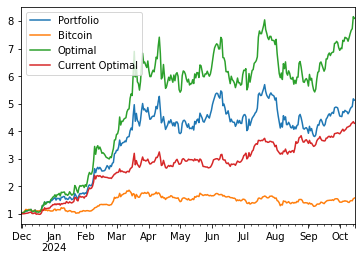

In [46]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [47]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

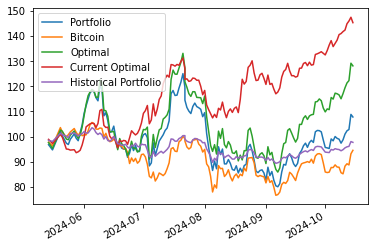

In [48]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [49]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-10-06,100.054652,88.789524,117.286984,137.043632,95.223930
2024-10-07,99.331836,87.943245,117.047215,138.334821,94.988501
2024-10-08,98.989034,87.853439,116.582559,140.540219,94.883881
2024-10-09,97.408977,85.671996,115.052828,140.963339,94.387560
2024-10-10,98.762926,85.233402,117.097134,141.749567,94.834515
2024-10-11,101.026050,88.304932,119.421877,142.347483,95.550868
2024-10-12,102.329526,89.240643,121.335189,144.853861,95.964525
2024-10-13,102.852756,88.764697,122.271924,145.938799,96.136533
2024-10-14,108.838242,93.190246,129.180670,147.429361,98.055526
2024-10-15,107.809928,94.576178,128.115875,145.282224,97.735321


## Volatilities

In [50]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.698695
dtype: float64

In [51]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.53159
dtype: float64

In [52]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.609456
Bitcoin            0.436564
Optimal            0.699755
Current Optimal    0.454873
dtype: float64

In [53]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2582957707900505

## Risk Contribution

In [54]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.071695,0.055670,0.009557,0.016836,0.001478,0.015358
BTCUSDT,0.236962,0.400000,0.047796,0.159153,0.062277,0.096877
OMUSDT,11.840591,0.466900,0.923518,0.765822,0.667708,0.098113
PEPEUSDT,0.160638,0.060889,0.016623,0.051182,0.012250,0.038932
SUIUSDT,0.016859,0.016541,0.002506,0.007006,0.000512,0.006494


In [55]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.242357,0.307578,0.390141,0.590333,0.532141,0.058191
TRXUSDT,0.167224,0.692422,0.609859,0.409667,0.351476,0.058191


In [56]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.260025,0.33,0.483511,0.425665,0.255802,0.169862
BTCUSDT,0.006774,0.28,0.235005,0.178980,0.045801,0.133179
SOLUSDT,-0.010125,0.13,0.098235,0.129006,0.025311,0.103696
JASMYUSDT,-0.019993,0.12,0.081953,0.165760,0.045448,0.120312
ETHUSDT,-0.014779,0.08,0.053447,0.061800,0.006426,0.055374
TRXUSDT,0.009660,0.04,0.040695,0.005801,0.000490,0.005311
BBUSDT,-0.011271,0.02,0.007153,0.032987,0.002641,0.030347


# Value At Risk

## Historical

In [57]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.056172835779309926, -0.08235456725396131)

In [58]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04850725415866401, -0.06833555561624596)

In [59]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [60]:
var=historical_var.iloc[row]
var

OMUSDT       0.013193
BTCUSDT     -0.020687
SOLUSDT     -0.008294
JASMYUSDT   -0.019867
ETHUSDT     -0.008443
TRXUSDT     -0.001581
BBUSDT      -0.002569
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048250
Name: 2024-08-05 00:00:00, dtype: float64

In [61]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.025317
BTCUSDT     -0.012799
SOLUSDT     -0.009383
JASMYUSDT   -0.011123
ETHUSDT     -0.004940
TRXUSDT     -0.000669
BBUSDT      -0.001873
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.066104
dtype: float64

## Parametric

In [62]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07250580152739111, -0.0929323908142472)

In [63]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05508127270927118, -0.07059896248482038)

## Multivariate

In [64]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06459938295205847, -0.08307391422882915)

In [65]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.054056647410096303, -0.06855817024416053)

In [66]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.021894
BTCUSDT     -0.010141
SOLUSDT     -0.007665
JASMYUSDT   -0.008046
ETHUSDT     -0.003337
TRXUSDT     -0.000289
BBUSDT      -0.001739
Portfolio   -0.053112
dtype: float64

## Copulas

### Gaussian Copula

In [67]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06542880762466123, -0.08411693589696251)

In [68]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.052222746558390355, -0.06709617459934845)

In [69]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021020
BTCUSDT     -0.010029
SOLUSDT     -0.007611
JASMYUSDT   -0.008806
ETHUSDT     -0.003532
TRXUSDT     -0.000318
BBUSDT      -0.001866
Portfolio   -0.053181
dtype: float64

### Student Copula

In [70]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06539632405247325, -0.08322327838965723)

In [71]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05312268805118831, -0.06860826825715699)

In [72]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.023183
BTCUSDT     -0.009718
SOLUSDT     -0.007463
JASMYUSDT   -0.008612
ETHUSDT     -0.003386
TRXUSDT     -0.000342
BBUSDT      -0.001578
Portfolio   -0.054282
dtype: float64

### Gumbel Copula

In [73]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12773006826069053, -0.1782404648966152)

In [74]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07125113622184852, -0.09823372326997075)

In [75]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.051337
BTCUSDT     -0.005407
SOLUSDT     -0.004915
JASMYUSDT   -0.006960
ETHUSDT     -0.001731
TRXUSDT      0.000289
BBUSDT      -0.000596
Portfolio   -0.070658
dtype: float64

### Monte Carlo

In [76]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [77]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07465823889569187, -0.09354370261621446)

In [78]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05634744985924657, -0.07097321095427911)

In [79]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.021324
BTCUSDT     -0.010792
SOLUSDT     -0.007389
JASMYUSDT   -0.010409
ETHUSDT     -0.003831
TRXUSDT     -0.000328
BBUSDT      -0.001991
Portfolio   -0.056063
dtype: float64

## VaR Violation

In [80]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.059330,-0.105711,-0.090436,-0.024366
2024-01-15,-0.059330,-0.105712,-0.086975,0.018648
2024-01-16,-0.059330,-0.106118,-0.086982,0.057349
2024-01-17,-0.059330,-0.108453,-0.089172,-0.034434
2024-01-18,-0.059330,-0.110605,-0.093131,-0.034357
...,...,...,...,...
2024-10-12,-0.023414,-0.045270,-0.038268,0.016021
2024-10-13,-0.023414,-0.045276,-0.039606,0.007720
2024-10-14,-0.023414,-0.048957,-0.040666,0.056503
2024-10-15,-0.022639,-0.048037,-0.038877,-0.008243


In [81]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031559,-0.084464,-0.080310,-0.016990
2024-05-29,-0.029395,-0.081638,-0.074621,-0.009864
2024-05-30,-0.029395,-0.070535,-0.064174,0.033820
2024-05-31,-0.029395,-0.069881,-0.061347,0.028944
2024-06-01,-0.029395,-0.071618,-0.064090,0.043966
...,...,...,...,...
2024-10-12,-0.031221,-0.044442,-0.043885,0.012902
2024-10-13,-0.031221,-0.044539,-0.043384,0.005113
2024-10-14,-0.031221,-0.056209,-0.051696,0.058195
2024-10-15,-0.028307,-0.052174,-0.046612,-0.009448


<AxesSubplot:>

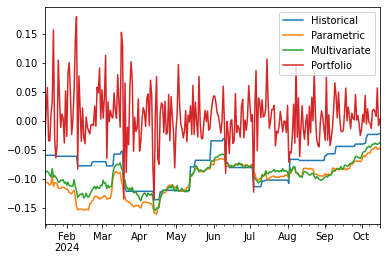

In [82]:
var_data.plot()

<AxesSubplot:>

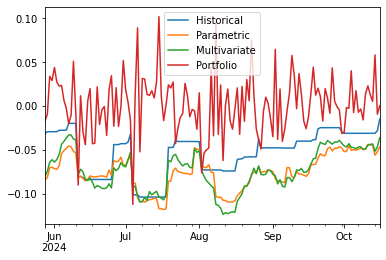

In [83]:
current_var_data.plot()

In [84]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021661,0.01083,0.01083
Kupiec Stat,5.893569,12.963297,12.963297
P-value,0.015196,0.000318,0.000318


In [85]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.056338,0.021127,0.021127
Kupiec Stat,0.115566,3.154472,3.154472
P-value,0.733894,0.075719,0.075719


## Principal Component Analysis

### Historical PCA

In [86]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78960538, 0.06876795, 0.05456834, 0.04485017, 0.04220817])

In [87]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014756
ADAUSDT     0.014971
ALGOUSDT    0.016465
APTUSDT     0.015739
ARBUSDT     0.016274
              ...   
WBTCUSDT    0.010412
WLDUSDT     0.022874
XECUSDT     0.015964
XLMUSDT     0.009959
XRPUSDT     0.009586
Name: PC1, Length: 62, dtype: float64

<AxesSubplot:>

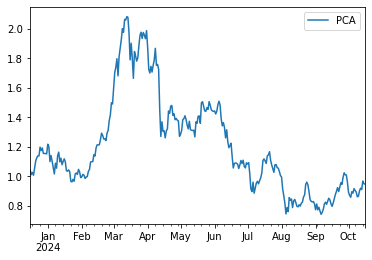

In [88]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

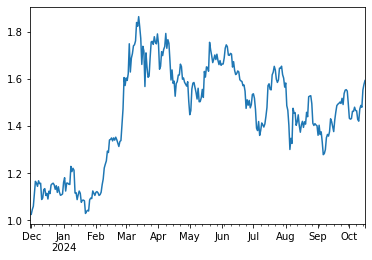

In [89]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [90]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.342317
ALGOUSDT     0.352526
ETHUSDT      0.358969
WBETHUSDT    0.359134
               ...   
BONKUSDT     0.973349
PEPEUSDT     1.006792
FLOKIUSDT    1.011595
WLDUSDT      1.061373
OMUSDT       1.322022
Length: 63, dtype: float64

<AxesSubplot:>

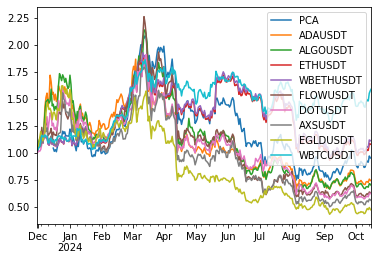

In [91]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

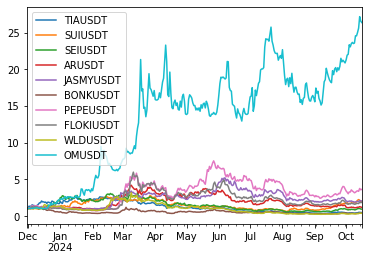

In [92]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [93]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67423525, 0.13810146, 0.08712568, 0.06868217, 0.03185544])

In [94]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095979
BTCUSDT      0.065298
SOLUSDT      0.105300
JASMYUSDT    0.155241
ETHUSDT      0.087383
TRXUSDT      0.014106
BBUSDT       0.240056
BNBUSDT      0.067881
PEPEUSDT     0.168756
Name: PC1, dtype: float64

<AxesSubplot:>

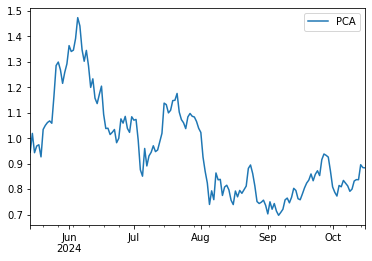

In [95]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

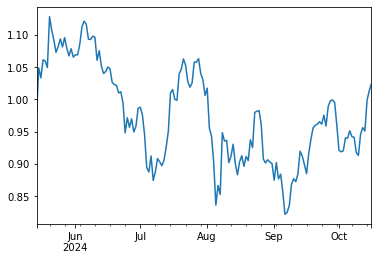

In [96]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [97]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.336380
SOLUSDT      0.344637
BTCUSDT      0.372358
BNBUSDT      0.378101
JASMYUSDT    0.428973
PEPEUSDT     0.482680
OMUSDT       0.558527
TRXUSDT      0.564973
BBUSDT       0.636169
dtype: float64

<AxesSubplot:>

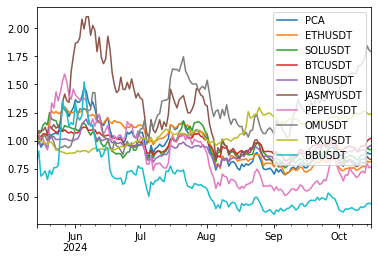

In [98]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [99]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.948336
BBUSDT       1.647416
JASMYUSDT    1.297662
SOLUSDT      1.168271
BTCUSDT      1.000000
OMUSDT       0.964091
ETHUSDT      0.957922
BNBUSDT      0.676166
TRXUSDT      0.271441
Name: BTCUSDT, dtype: float64

In [100]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     2.250107
JASMYUSDT    1.491543
BBUSDT       1.410342
SOLUSDT      1.329891
ETHUSDT      1.053992
BTCUSDT      1.000000
BNBUSDT      0.602270
OMUSDT       0.456335
TRXUSDT     -0.168955
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [101]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
